### Preprocessing
* http://cs231n.github.io/neural-networks-2/#datapre
* http://www.robots.ox.ac.uk/~vgg/practicals/cnn/#getting-started
* https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html
* https://stackoverflow.com/a/10169025/5151861
* augmentation tf+keras http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

#### Augmentation
* rotation: random with angle between 0° and 360° (uniform)
* translation: random with shift between -10 and 10 pixels (uniform)
* rescaling: random with scale factor between 1/1.6 and 1.6 (log-uniform)
* flipping: yes or no (bernoulli)
* shearing: random with angle between -20° and 20° (uniform)
* stretching: random with stretch factor between 1/1.3 and 1.3 (log-uniform)
* whitening
* https://www.tensorflow.org/api_docs/python/tf/image
* https://github.com/aleju/imgaug
* http://augmentor.readthedocs.io/en/master/
* https://github.com/analysiscenter/dataset

* uint8 0 to 255
* uint16 0 to 65535
* uint32 0 to 232
* float -1 to 1 or 0 to 1
* int8 -128 to 127
* int16 -32768 to 32767
* int32-231 to 231 - 1

In [102]:
from scipy import ndimage
import numpy as np
import pandas as pd
import os
from IPython.display import display, Image
from scipy import misc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
train_df = pd.read_csv('data/data_analys.csv', index_col=0)

### Load train transformed

In [3]:
%%time

dir_train_transformed = 'data/train_transformed'
# img parameters
img_shape = (64, 64)
channels = 3
img_shape_flattened = img_shape[0] * img_shape[1] * channels
img_qty = train_df.shape[0]

# initialize X,y
X = np.empty(shape=(img_qty, img_shape_flattened), dtype=np.int8)
y = np.empty(shape=(img_qty,), dtype=np.uint16)

# read images
for i,f_name in enumerate(os.listdir(dir_train_transformed)):
    if i % 5000 == 0:
        print('{:6d}/{:6d} images loaded'.format(i, img_qty))
    
    img_path = os.path.join(dir_train_transformed, f_name)
    X[i, :] = misc.imread(img_path).flatten('C') # since img is np.ndarray, flatten in row-style
    y[i] = train_df.loc[train_df['image_name'] == f_name, 'target'].iloc[0]

     0/ 22897 images loaded
  5000/ 22897 images loaded
 10000/ 22897 images loaded
 15000/ 22897 images loaded
 20000/ 22897 images loaded
CPU times: user 1min 16s, sys: 3.96 s, total: 1min 20s
Wall time: 1min 28s


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

### Find optimal PCA components

In [7]:
%%time
pca = PCA(n_components=5000).fit(X_train)
print('{}'.format(np.cumsum(pca.explained_variance_ratio_)))

[ 0.11819607  0.15731014  0.18937642 ...,  0.94386439  0.94388505
  0.94390567]
CPU times: user 34min, sys: 1min 53s, total: 35min 53s
Wall time: 15min 46s


In [9]:
round(np.cumsum(pca.explained_variance_ratio_)[-1400], 4)

0.90169999999999995

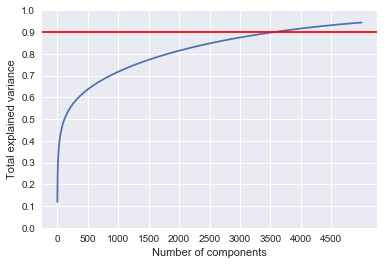

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 5000, 500))
plt.axhline(0.9, c='r');

In [ ]:
%%time
pca = PCA(n_components=3600)

X_train_sc = X_train / 255
X_train_pca = pca.fit_transform(X_train_sc)

In [ ]:
%%time
X_test_sc = X_test / 255
X_test_pca = pca.transform(X_test_sc)

In [ ]:
reg = LogisticRegression(random_state=42, C=0.1, max_iter=50, verbose=2, n_jobs=-1, class_weight='balanced')
reg.fit(X_train_pca, y_train)

In [ ]:
accuracy(y_train, reg.predict(X_train_pca))
accuracy(y_test, reg.predict(X_test_pca))

In [ ]:
def accuracy(y, y_pred):
    print('accuracy: {}'.format(accuracy_score(y, y_pred)))

### Making pipeline

In [ ]:
pca = PCA(n_components=3600)
svc = LogisticRegression(random_state=42, C=0.1, max_iter=50, verbose=2, n_jobs=-1, class_weight='balanced')
scaler = StandardScaler()

model = Pipeline((('scaler', scaler), ('dim_reduction', pca), ('classifier', svc)))

In [ ]:
%%time
model.fit(X_train, y_train)

### Load test transformed

In [ ]:
%%time

train_df = pd.read_csv('data/data_analys.csv', index_col=0)
dir_test_transformed = 'data/test_transformed'

X_val = np.empty(shape=(img_qty, img_shape_flattened), dtype=np.int8)

# read images
for i,f_name in enumerate(os.listdir(dir_test_transformed)):
    if i % 2000 == 0:
        print('{} images loaded'.format(i))
    
    img_path = os.path.join(dir_test_transformed, f_name)
    X_val[i, :] = misc.imread(img_path).flatten('C') # since img is np.ndarray, flatten in row-style

In [ ]:
%%time

X_test_pca = pca.transform(X_test)
y_pred = svc.predict(X_test_pca)

sub = pd.DataFrame(
    data=[row for row in zip(os.listdir(dir_test_transformed), y_pred.astype(int).tolist())],
    columns=['image', 'class']
)
sub.to_csv('lr_baseline.csv', encoding='utf-8', index=False)

## Keras starts here

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [93]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, img_width, img_height)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Conv2D(32, (3, 3), dim_ordering="th"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), data_format="channels_first")`
  del sys.path[0]


In [89]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [90]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [92]:
train_data_dir = 'data/train'
validation_data_dir = 'data/test'
img_width = 32
img_height = 32
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Found 22897 images belonging to 257 classes.
Found 0 images belonging to 0 classes.
Epoch 1/50


ValueError: Error when checking input: expected conv2d_26_input to have shape (None, 3, 32, 32) but got array with shape (16, 32, 32, 3)